In [1]:
# load required libraries
options(stringsAsFactors = F)
suppressPackageStartupMessages({
library(Seurat)
library(ggplot2)
library(ggpubr)
library(viridis)
library(clusterProfiler)
library(org.Hs.eg.db)
library(enrichplot)
library(msigdbr)
library(dplyr)
library(Matrix)
library(Hmisc)
})
set.seed(123)

In [2]:
# calculate fold change pre-HEC vs other
sample <- readRDS("../1_EHT_RNA_Preprocessing/sample_human_annotated.rds")
prehec_fc <- FoldChange(sample, `ident.1` = "pre-HEC")

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (25.14% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



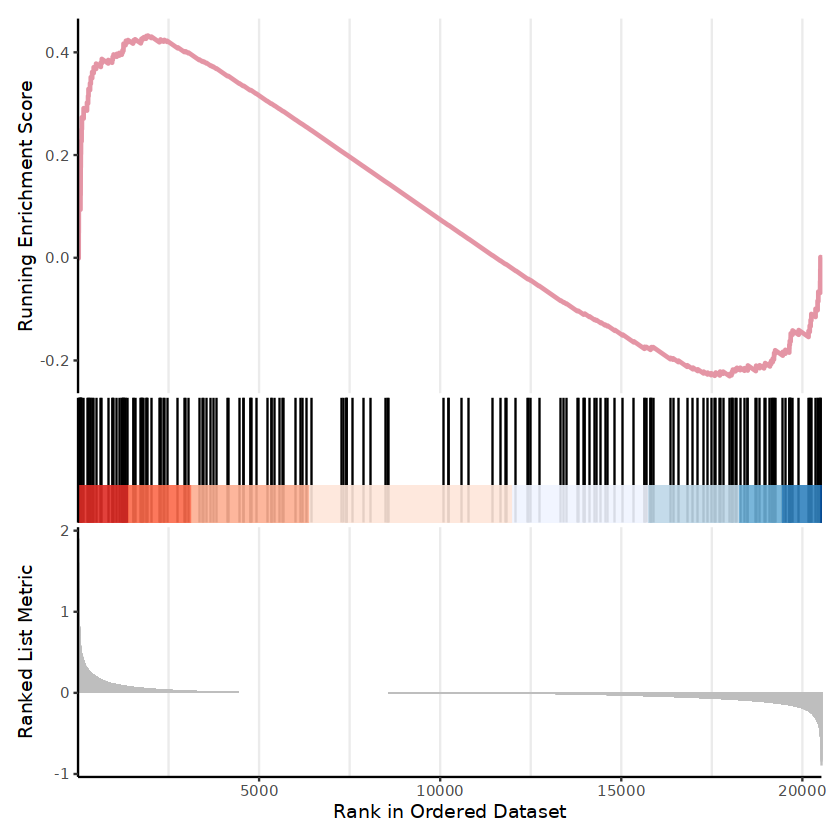

In [3]:
# gene set enrichment analysis msigdb
m_df <- msigdbr(species = "Homo sapiens")
m_t2g <- msigdbr(species = "Homo sapiens", category = "H") %>% dplyr::select(gs_name, gene_symbol)
prehec_fc_ranked <- prehec_fc[order(prehec_fc$avg_log2FC, decreasing = T), ]
gene_list <- prehec_fc_ranked$avg_log2FC
names(gene_list) <- rownames(prehec_fc_ranked)
em <- GSEA(gene_list, TERM2GENE = m_t2g)
gseaplot2(em, geneSetID = c("HALLMARK_HYPOXIA"), color = c("#E495A5"))

In [4]:
# GO GSEA
ego <- gseGO(geneList     = gene_list,
              OrgDb        = org.Hs.eg.db,
              keyType      = "SYMBOL",
              ont          = "BP",
              minGSSize    = 100,
              maxGSSize    = 500,
              pvalueCutoff = 0.05,
              verbose      = FALSE)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (25.14% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”


In [5]:
# output the go gsea results
write.csv(ego, "meta/ego_prehec_human.csv")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Picking joint bandwidth of 0.0376

Warning message:
“Removed 13 rows containing non-finite values (`stat_density_ridges()`).”
Picking joint bandwidth of 0.0376

Warning message:
“Removed 13 rows containing non-finite values (`stat_density_ridges()`).”


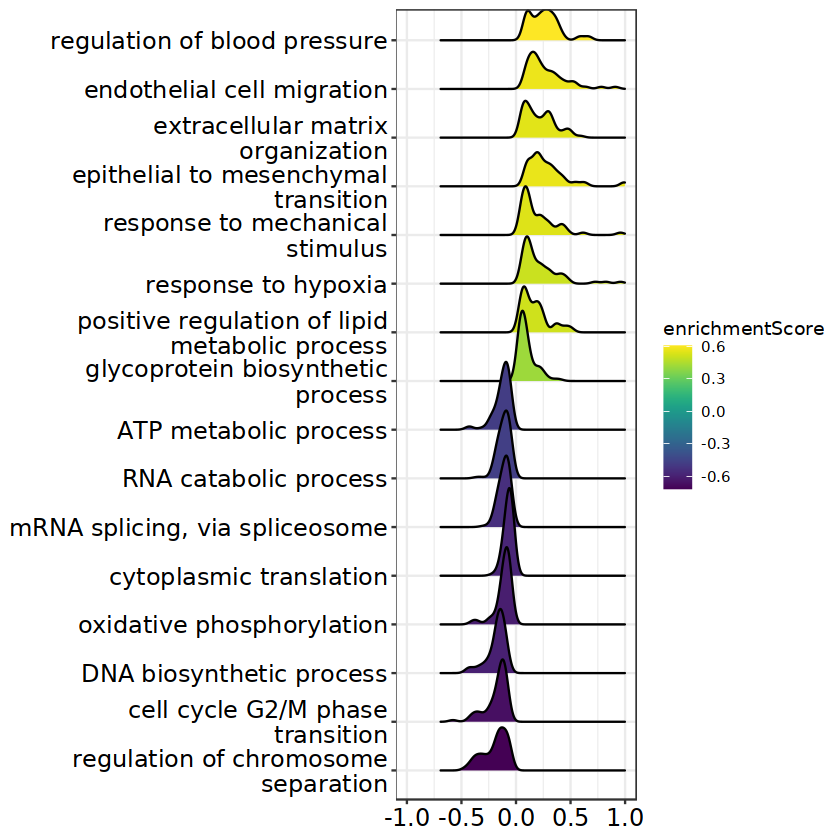

In [6]:
# plot selected GO results
# go_selected <- c('epithelial to mesenchymal transition','endothelium development','angiogenesis','regulation of blood pressure','response to mechanical stimulus','endothelial cell migration','extracellular matrix organization','regulation of ossification','external encapsulating structure organization','regulation of wound healing','cell cycle G2/M phase transition','nuclear division','mRNA splicing, via spliceosome','cytoplasmic translation','oxidative phosphorylation','RNA modification','ribosome biogenesis','mRNA transport','DNA biosynthetic process','regulation of chromosome separation')
go_selected <- c('epithelial to mesenchymal transition','regulation of blood pressure','response to mechanical stimulus','endothelial cell migration','extracellular matrix organization','positive regulation of lipid metabolic process','glycoprotein biosynthetic process','response to hypoxia','cell cycle G2/M phase transition','DNA biosynthetic process','RNA catabolic process','regulation of chromosome separation','mRNA splicing, via spliceosome','cytoplasmic translation','oxidative phosphorylation','ATP metabolic process')
ego_selection <- ego[ego$Description %in% go_selected, asis = T]
ridgeplot(ego_selection, fill = "enrichmentScore") + xlim(-1, 1) + scale_fill_viridis(option = "D")
ggsave("figure/ridgeplot_ego_selection_prehec.pdf", width = 8, height = 10)

In [7]:
# load the sample
sample_TE <- readRDS("../5_EHT_TE_Silencing_Relaxation/sample_human_TE_EHT.rds")
sample_TE

An object of class Seurat 
58840 features across 4158 samples within 2 assays 
Active assay: SCT (21042 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, tsne, umap

In [8]:
# score the TE related gene sets
te_silencers <- read.csv("meta/TE_silencers_all_average_expression_human.csv", row.names = 1)
te_silencers <- rownames(subset(te_silencers, Down == TRUE))

te_module_hg38 <- read.csv("meta/te_module_hg38.csv", row.names = 1)
te_hme5_good <- rownames(subset(te_module_hg38, kME >= 0.3))

hypoxia_response_genes <- c('SLC2A3','SOX7','EDN1','CXCR4','PDLIM1','EPAS1','MMP2','ITPR2','CD24','THBS1','AQP1','PLAT','GATA6','HIPK2','PLOD1','CFLAR','VEGFC','MMP14','CXCL12','HSD11B2','NOTCH1','ADM','PLOD2','PTGS2','ITPR1','FOS','EPHA4','ACE','ATP1B1','ACTN4','PLK3','ACVRL1','PAM','ADAM17','MALAT1','DNMT3A','TGFB2','HSP90B1','DIO3','REST','NPPC','BNIP3L','PRKAA1','DDAH1','PINK1','CYBA','HYOU1','JUND','PTEN','MDM4','NPEPPS','SLC2A1','P4HB','HIF3A','PTGIS','TGFBR2','RBPJ','STUB1','WTIP','HP1BP3','CRYAB','CITED2','ERO1A','HMOX2')

sample_score <- sample_TE
sample_score <- AddModuleScore(sample_score, features = list(te_silencers, te_hme5_good, hypoxia_response_genes), assay = "SCT")
colnames(sample_score@meta.data)[13:15] <- c("TE_Silencers","TEs_HME5","Hypoxia")

In [9]:
# plot all hypoxia related genes
hypoxia_response_genes <- c('SLC2A3','SOX7','EDN1','CXCR4','PDLIM1','EPAS1','MMP2','ITPR2','CD24','THBS1','AQP1','PLAT','GATA6','HIPK2','PLOD1','CFLAR','VEGFC','MMP14','CXCL12','HSD11B2','NOTCH1','ADM','PLOD2','PTGS2','ITPR1','FOS','EPHA4','ACE','ATP1B1','ACTN4','PLK3','ACVRL1','PAM','ADAM17','MALAT1','DNMT3A','TGFB2','HSP90B1','DIO3','REST','NPPC','BNIP3L','PRKAA1','DDAH1','PINK1','CYBA','HYOU1','JUND','PTEN','MDM4','NPEPPS','SLC2A1','P4HB','HIF3A','PTGIS','TGFBR2','RBPJ','STUB1','WTIP','HP1BP3','CRYAB','CITED2','ERO1A','HMOX2')
hypoxia_response_genes_exp <- AverageExpression(sample, features = hypoxia_response_genes, assays = "SCT")
write.csv(hypoxia_response_genes_exp$SCT, "meta/hypoxia_response_genes_average_exp.csv")
p <- DotPlot(sample, features = rev(hypoxia_response_genes), cols = c("grey90","red3"), group.by = "celltype", scale.by = "size") + coord_flip() + theme(axis.text.x = element_text(angle = 45, hjust = 1))
png("figure/hypoxia_response_genes_human.png", width = 600, height = 1500)
print(p)
dev.off()

png 
  2

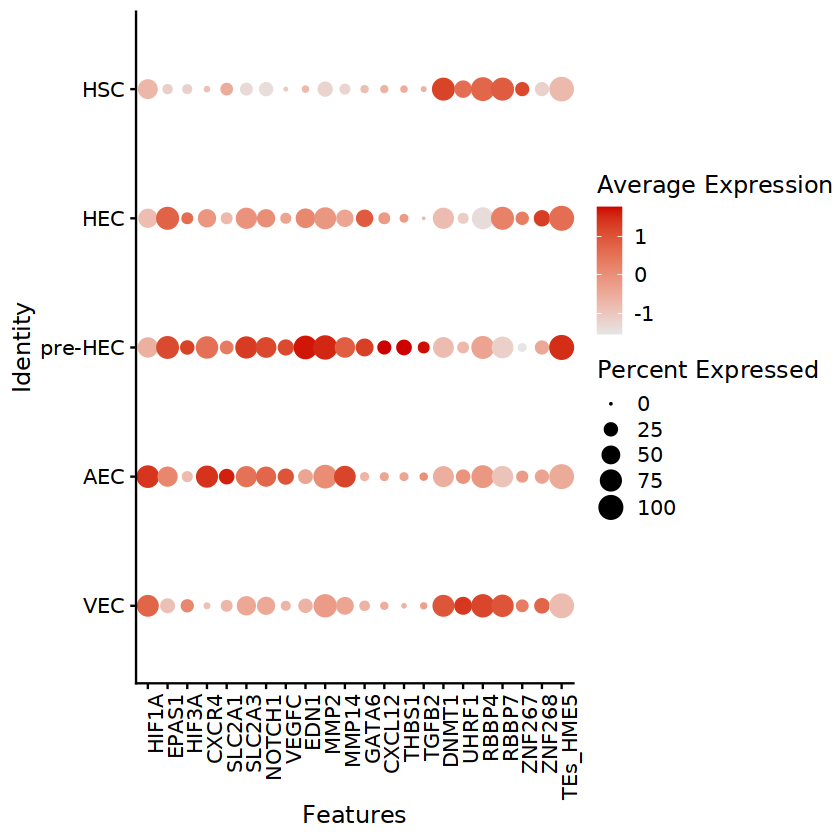

In [10]:
# plot selected hypoxia related genes
hypoxia_response_gene_selected <- c("HIF1A", "EPAS1", "HIF3A", "CXCR4", "SLC2A1","SLC2A3", "NOTCH1","VEGFC","EDN1", "MMP2", "MMP14","GATA6", "CXCL12","THBS1","TGFB2","DNMT1","UHRF1","RBBP4","RBBP7","ZNF267","ZNF268","TEs_HME5")
DotPlot(sample_score, features = hypoxia_response_gene_selected, cols = c("grey90","red3"), group.by = "celltype", scale.by = "size") + theme(axis.text.x = element_text(angle = 90, hjust = 1))
ggsave("figure/hypoxia_response_genes_selected_human.pdf", width = 8, height = 3)

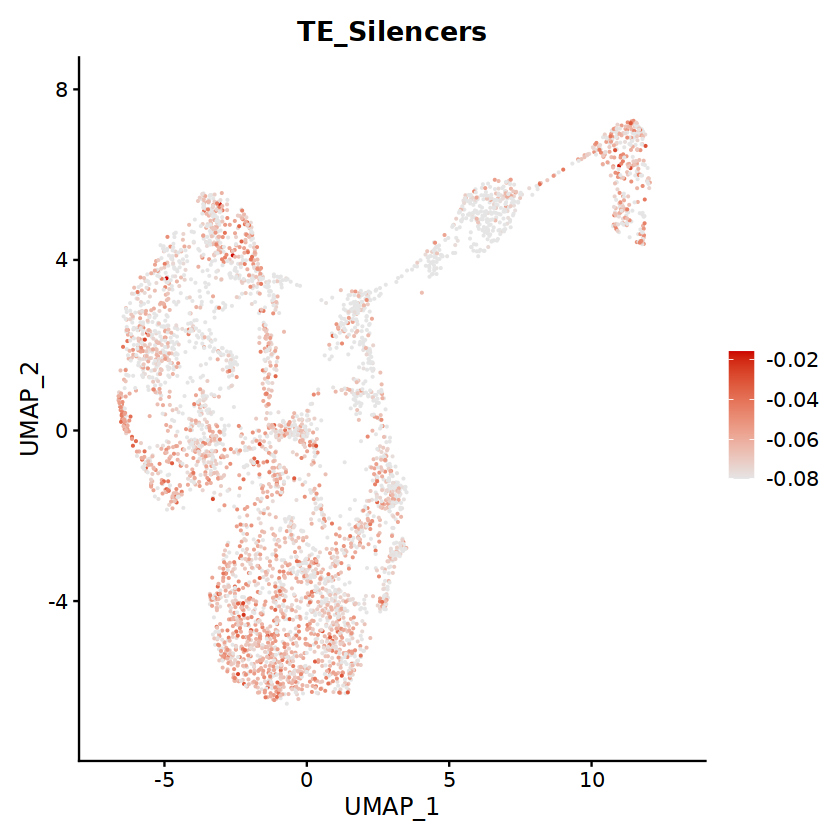

In [11]:
# plot TE silencers
FeaturePlot(sample_score, features = c("TE_Silencers"), cols = c("grey90", "red3"), min.cutoff = -0.08, pt.size = 0.1)
ggsave("figure/featureplot_TE_silencers_human.pdf", width = 5, height = 5)

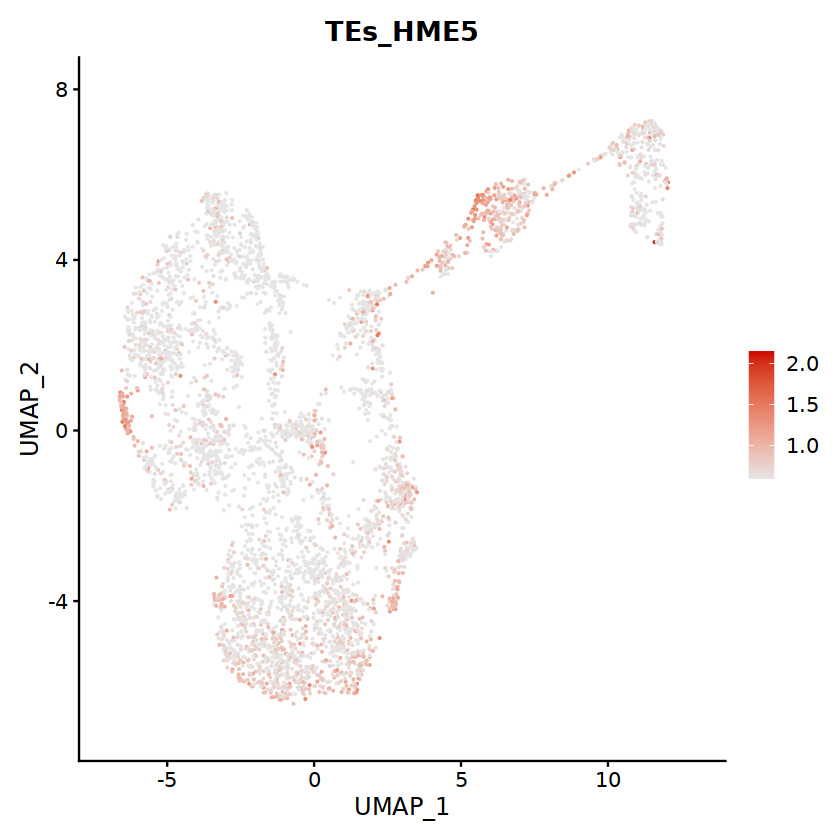

In [12]:
# plot TEs in HME5 (kME >= 0.3)
FeaturePlot(sample_score, features = c("TEs_HME5"), cols = c("grey90", "red3"), min.cutoff = 0.6, pt.size = 0.1)
ggsave("figure/featureplot_TEs_HME5_human.pdf", width = 5, height = 5)

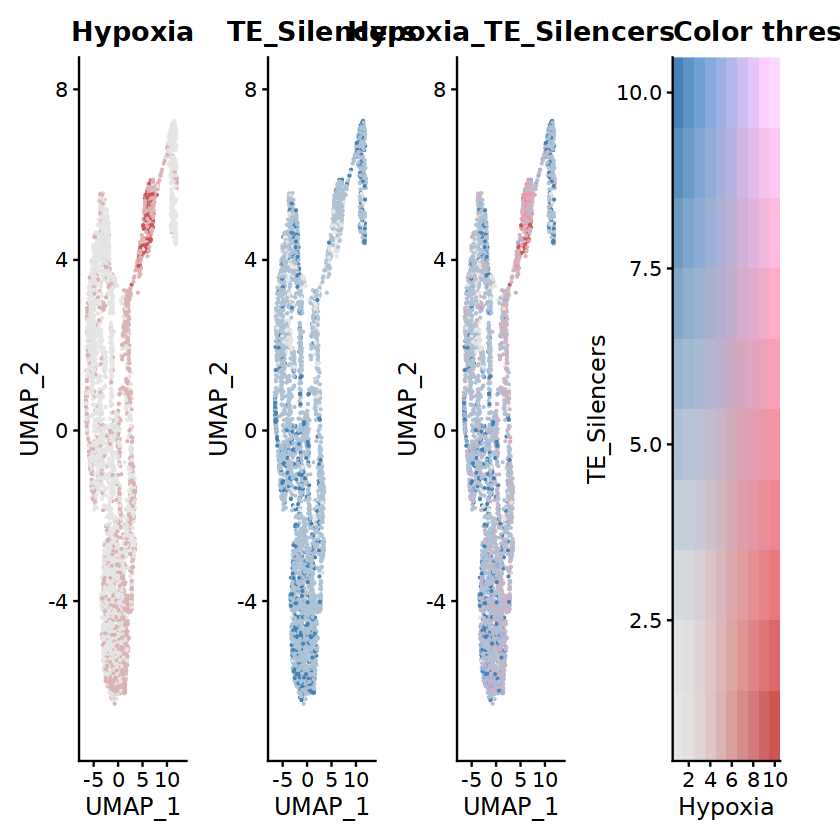

In [13]:
# plot Hypoxia vs TE_Silencers co-embedding
FeaturePlot(sample_score, features = c("Hypoxia", "TE_Silencers"), blend = TRUE, cols = c("grey90", "indianred3","steelblue"), pt.size = 0.1, blend.threshold = 0.1)
ggsave("figure/featureplot_Hypoxia_TE_silencers_human.pdf", width = 11, height = 3)

In [14]:
# normalization scores from 0 to 1
sample_score$TE_Silencers_01 <- (sample_score$TE_Silencers - min(sample_score$TE_Silencers)) / (max(sample_score$TE_Silencers) - min(sample_score$TE_Silencers))
sample_score$TEs_HME5_01 <- (sample_score$TEs_HME5 - min(sample_score$TEs_HME5)) / (max(sample_score$TEs_HME5) - min(sample_score$TEs_HME5))
sample_score$Hypoxia_01 <- (sample_score$Hypoxia - min(sample_score$Hypoxia)) / (max(sample_score$Hypoxia) - min(sample_score$Hypoxia))
#sample_score$TE_Inflammatory_01 <- (sample_score$TE_Inflammatory - min(sample_score$TE_Inflammatory)) / (max(sample_score$TE_Inflammatory) - min(sample_score$TE_Inflammatory))
#sample_score$TE_Immune_01 <- (sample_score$TE_Immune - min(sample_score$TE_Immune)) / (max(sample_score$TE_Immune) - min(sample_score$TE_Immune))
#TE_trend_all <- data.frame(score = c(sample_score$TE_Silencers_01, sample_score$TEs_HME5_01, sample_score$TE_Sensors_01, sample_score$TE_Inflammatory_01, sample_score$TE_Immune_01), celltype = rep(sample_score$celltype, 5), score_type = rep(c("TE_Silencers", "TEs_HME5", "TE_Sensors", "TE_Inflammatory", "TE_Immune"), each = nrow(sample_score@meta.data)))
TE_trend_all <- data.frame(score = c(sample_score$TE_Silencers_01, sample_score$TEs_HME5_01, sample_score$Hypoxia_01), celltype = rep(sample_score$celltype, 3), score_type = rep(c("TE_Silencers", "TEs_HME5", "Hypoxia"), each = nrow(sample_score@meta.data)))

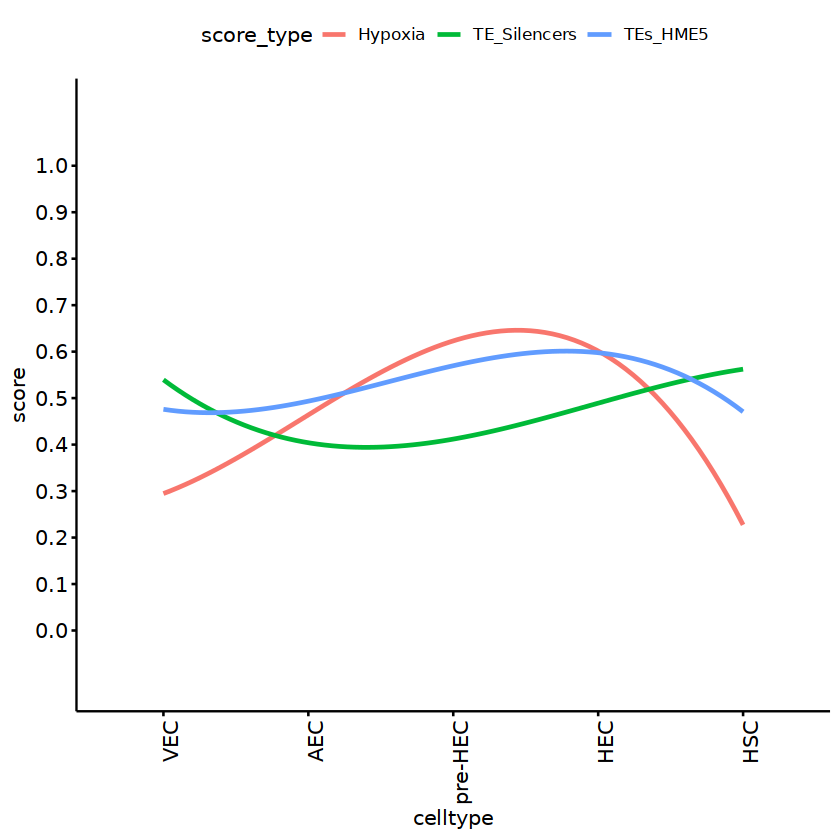

In [15]:
# plot the average expression trend
ggviolin(TE_trend_all, x = "celltype", y = "score", color = "white") + geom_smooth(method = lm, formula = y ~ splines::bs(x, 3), se = F, level = 0.95, aes(color = score_type, group = score_type)) + theme(axis.text.x=element_text(angle=90, hjust=1)) + scale_y_continuous(breaks = seq(0, 1, by = 0.1))

In [16]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /root/miniconda3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] Hmisc_5.0-1           Matrix_1.5-4          dplyr_1.1.1          
 [4] msigdbr_7.5.1         enrichplot_1.18.4     org.Hs.eg.db_3.16.0  
 [7] AnnotationDbi_1.60.2  IRanges_2.32.0        S4Vectors_0.36.2     
[10] Biobase_2.58.0        BiocGenerics_0.44.0   clusterProfiler_4.6.2
[13] viridis_0.6.2         viridisLite_0.4.1     ggpubr_0.6.0         
[16] ggplot2_3.4.2         SeuratObject_4.1.3   